In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import six
import sys
import random
import seaborn as sns
import math
from matplotlib.cbook import flatten
from re import A
import timeit
import os

import sklearn 
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,accuracy_score,f1_score,mean_squared_error,confusion_matrix, matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
#from skrules import SkopeRules # in skope_rules.py, from sklearn.externals import six must be changed with import six

In [2]:
from server_device_weighted import * 

In [3]:
node1_df = pd.read_csv(r".\Data\node1.csv").drop(['Unnamed: 0'] ,axis=1)
node2_df = pd.read_csv(r".\Data\node2.csv").drop(['Unnamed: 0'] ,axis=1)

In [4]:
print("The size of Node 1", node1_df.shape)
print("\nThe size of Node 2", node2_df.shape)

The size of Node 1 (13262, 8)

The size of Node 2 (13262, 8)


In [5]:
VP_df = pd.concat([node1_df, node2_df], ignore_index=True)

In [6]:
# Calculate the minimum and maximum values for each column in df1
df1_min = node1_df.min()
df1_max = node1_df.max()

# Calculate the minimum and maximum values for each column in df2
df2_min = node2_df.min()
df2_max = node2_df.max()

# Find the minimum values between df1_min and df2_min for each column
min_= pd.concat([df1_min, df2_min], axis=1).min(axis=1)

# Find the maximum values between df1_max and df2_max for each column
max_= pd.concat([df1_max, df2_max], axis=1).max(axis=1)




In [7]:
from sklearn.tree import _tree
from sklearn import tree


def compute_error(rule, target_class_index, total_samples_all_other_classes):
    error_count = 0

    # Extracting the numpy array from the last element of the rule
    class_samples_array, _ = rule[-1]

    # Extracting the class samples for all other classes except the target class
    for i, class_samples in enumerate(class_samples_array[0]):
        if i != target_class_index:
            error_count += class_samples

    # Calculating the error percentage
    error_percentage = (error_count / total_samples_all_other_classes) * 100

    return error_percentage


def get_rules(tree, feature_names, class_names, Y, x_train, GP):
    tree_ = tree.tree_
    feature_name = [feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
                    for i in tree_.feature]

    paths = []
    path = []

    def recurse(node, path, paths):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"{name} <= {np.round(threshold, 3)}"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"{name} > {np.round(threshold, 3)}"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]

    recurse(0, path, paths)

    # Sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]

    class_names = sorted(Y.unique())
    num_classes = len(class_names)
    total_samples_classes = [np.sum(Y == class_name) for class_name in class_names]

    rules = []

    for path in paths:
        rule = "if "

        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)

        if (GP == 1):
            rule += " and m <= 1000 "
        elif (GP == 2):
            rule += " and m >= 1000 "
        
        rule += " then "

        if class_names is None:
            rule += "response: " + str(np.round(path[-1][0][0][0], 3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)

            rule += f"class: {class_names[l]}"
            rule += f" | based on {path[-1][1]:,} samples"
            rule += f" | total samples {total_samples_classes[l]}"
            rule += f" | coverage {np.round(100.0 * path[-1][1] / total_samples_classes[l], 2)}%"
            
            total_samples_all_other_classes = sum(total_samples_classes) - total_samples_classes[l]
            error_percentage = compute_error(path, l, total_samples_all_other_classes)
            covering_percentage = np.round(100.0 * path[-1][1] / total_samples_classes[l], 2)
            
            rule_relevance = covering_percentage * (1 - error_percentage)
            rule += f" | error {np.round(error_percentage, 2)}%"
            rule += f" | relevance {np.round(rule_relevance, 2)}"
        
        rules += [rule]

    return rules

In [8]:
def clfDecision(X_trn, y_trn):    

    model = DecisionTreeClassifier().fit(X_trn.values, y_trn.values) #, max_depth=5,random_state=0
    #y_pred = model.predict(X_tst)

    return model

In [9]:
from sklearn.tree import export_text
import sys
import pickle
import sys
from pympler import asizeof


def get_tree_metrics(tree):
    """
    Calculate the metrics of the decision tree.
    Args:
        tree (DecisionTreeClassifier): The trained decision tree.
    Returns:
        dict: A dictionary containing tree metrics.
    """
    n_nodes = tree.tree_.node_count
    n_leaf_nodes = sum(tree.tree_.children_left == -1)
    n_internal_nodes = n_nodes - n_leaf_nodes
    max_depth = tree.tree_.max_depth
    depths = tree.tree_.max_depth

    return {
        "n_nodes": n_nodes,
        "n_leaf_nodes": n_leaf_nodes,
        "n_internal_nodes": n_internal_nodes,
        "max_depth": max_depth,
        "depths": depths
    }

def get_model_size(model):
    """
    Calculate the size of the model in bytes.
    Args:
        model: The trained decision tree model.
    Returns:
        int: The size of the model in bytes.
    """
    return sys.getsizeof(pickle.dumps(model))


In [11]:
acc_total = []
f1_total = []
mcc_total = []

tree_sizes = []
tree_depths = []
tree_internal_nodes = []
tree_leaf_nodes = []
model_sizes = []


def split_data_into_batches(data, batch_size):
  """Splits data into batches of specified size.

  Args:
      data (pd.DataFrame): Data to be split.
      batch_size (int): Size of each batch.

  Returns:
      list: List of batches (DataFrames).
  """
  batches = [data.iloc[i:i + batch_size] for i in range(0, len(data), batch_size)]
  return batches

    

def create_local_model_and_extract_rules(data_batch, target_batch, feature_names, class_names, folder_path, filename, GP):
  """Creates a local decision tree model, extracts rules, and saves them.

  Args:
      data_batch (pd.DataFrame): Batch of features.
      target_batch (pd.Series): Batch of target variables.
      feature_names (list): List of feature names.
      class_names (list, optional): List of target class names (optional).
      folder_path (str): Path to the folder for saving the file.
      filename (str): Filename for saving the rules.

  Returns:
      None
  """
  # Train local decision tree model (assuming clfDecision works with DataFrames)
  model = clfDecision(data_batch, target_batch)

  # Extract rules in a human-readable format
  rules = get_rules(model, feature_names, class_names, target_batch, data_batch,GP)

  # Create folder if it doesn't exist
  os.makedirs(folder_path, exist_ok=True)

  with open(os.path.join(folder_path, filename), "w") as f:
    for r in rules:
      f.write(r)
      f.write('\n')
      f.write('\n')  # Add extra line breaks between rules


def read_and_merge_rules(directory_path, min_coverage=3.0):
  """
  Reads all txt files in a directory, parses rules, and merges them.

  Args:
      directory_path: Path to the directory containing rule files.
      min_coverage: Minimum coverage threshold for including rules (default: 3.0).

  Returns:
      list: Merged list of rules from all files.
  """

  all_rules = []

  # Loop through all files in the directory
  for filename in os.listdir(directory_path):
    if filename.endswith(".txt"):
      file_path = os.path.join(directory_path, filename)
      rules = load_rules_from_file(file_path, min_coverage)
      all_rules.append(rules)  # Extend the list with rules from each file

  return all_rules

from collections import defaultdict

def extract_boost_centers(merged_rules, relevance_threshold=10.0):
    boost_centers = defaultdict(list)
    for rule_set in merged_rules:
        for rule in rule_set:
            if rule['coverage'] >= relevance_threshold:
                for cond in rule['conditions']:
                    feat = cond['feature']
                    try:
                        val = float(cond['value'])
                        boost_centers[feat].append(val)
                    except:
                        continue  # skip non-numeric values
    return boost_centers


# Hyperparameters (adjust as needed)
test_size = 0.2
batch_size = 200 # Number of sample per device
num_rounds = 250
number_clients = 6

# Single folder path for saving all rules
rules_folder = "All_Rules"  # Customize folder name

feature_names = ['N','F0','m','d_ms' ,'d0', 'v0', 'prob']  # Replace with actual feature names
target_label_names = ['0', '1']  # Replace with actual target labels

# Split data into training and testing sets for each group
train_1, test_1 = train_test_split(node1_df, test_size=test_size, shuffle=True, random_state=42)
train_2, test_2 = train_test_split(node2_df, test_size=test_size, shuffle=True, random_state=38)

# Split training data into batches for each group
train_1_batches = split_data_into_batches(train_1, batch_size)
train_2_batches = split_data_into_batches(train_2, batch_size)

# Split training data into batches for each group
test_1_batches = split_data_into_batches(test_1, batch_size)
test_2_batches = split_data_into_batches(test_2, batch_size)

# Concatenate along rows (axis=0)
test_total = pd.concat([test_1, test_2], axis=0)

print("test_total",len(test_total))
print("num batches:", len(train_1_batches) + len(train_2_batches))

start_time = timeit.default_timer()
for round in range(1, num_rounds + 1):
    print(f"Round {round}")
    
    # Sample 20 random batches from each group
    sampled_batches_1 = random.sample(train_1_batches, number_clients // 2)
    sampled_batches_2 = random.sample(train_2_batches, number_clients // 2)
  
    for i, batch in enumerate(sampled_batches_1):
        data_batch = batch.iloc[:, :-1]
        target_batch = batch.iloc[:, -1]
        num_devices_batch_1 = len(batch)  # Get number of devices in the batch
        # Create local model and extract rules for group 1, device i+1
        rules = create_local_model_and_extract_rules(data_batch, target_batch, feature_names, target_label_names, rules_folder, f"Decision_rules_GP1_device{i+1}.txt", 1)



    for i, batch in enumerate(sampled_batches_2):
        data_batch = batch.iloc[:, :-1]
        target_batch = batch.iloc[:, -1]
        num_devices_batch_2 = len(batch)  # Get number of devices in the batch
        # Create local model and extract rules for group 2, device i+1
        rules = create_local_model_and_extract_rules(data_batch, target_batch, feature_names, target_label_names, rules_folder, f"Decision_rules_GP2_device{i+1}.txt", 2)


    #===============================================================================================================================================================
    #================================================================  SERVER =============================================================================
    #===============================================================================================================================================================
    
    # Generating Random Point
    n = 5000
    points = []

    
    # Define the column names and their corresponding min/max values
    columns = feature_names  # from above
    min_values = [VP_df[col].min() for col in columns]
    max_values = [VP_df[col].max() for col in columns]
    min_ = {col: VP_df[col].min() for col in columns}
    max_ = {col: VP_df[col].max() for col in columns}

    
    directory_path = "./All_Rules"
    merged_rules = read_and_merge_rules(directory_path)

    boost_centers = extract_boost_centers(merged_rules)

    def relevance_weighted_sample(min_val, max_val, centers, p_bias=0.3, scale_ratio=0.05):
        if centers and random.random() < p_bias:
            center = random.choice(centers)
            std = scale_ratio * (max_val - min_val)
            return np.clip(np.random.normal(loc=center, scale=std), min_val, max_val)
        else:
            return random.uniform(min_val, max_val)

    
    # Generate relevance-weighted values within the min/max range for each column
    for j in range(n):
        row = []
        for col in columns:
            row.append(relevance_weighted_sample(min_[col], max_[col], boost_centers.get(col, [])))
        points.append(row)


    df_rnd = pd.DataFrame(points, columns=columns)  # ✅ dynamically matches adult dataset features
       
    instances_np = np.array(points)

    # Assuming DataFrame is called df_rnd
    for column in df_rnd.columns:
        if not pd.to_numeric(df_rnd[column], errors='coerce').notnull().all():
            print(f"Column '{column}' contains non-numeric values.")


    final_labels = []
    
    def convert_output(output):
        if isinstance(output, np.ndarray):
            return int(output[0])
        elif output == 'No':
            return 'No'
        else:
            return output
    
    # Create a list to store the final predicted labels for all instances
    final_labels = []
    
    # Iterate through each instance and predict labels based on the rules
    for instance in instances_np:
        # Predict the label for the current instance using the merged rules
        final_label = predict_label(instance, merged_rules, columns)
        final_labels.append(final_label)

    # Create a DataFrame to store the final predictions and original rules
    predictions_df = pd.DataFrame(instances_np, columns=columns)
    predictions_df['Prediction(merged_majority)'] = final_labels

    output_file_path = 'merged_rules.txt'


    # Write the merged rules to the txt file
    write_merged_rules_to_txt(output_file_path, merged_rules)
    predictions_df = predictions_df.dropna()
    X_trn_server, X_tst_server, y_trn_server, y_tst_server = train_test_split(predictions_df.loc[:,['N','F0','m','d_ms' ,'d0', 'v0', 'prob']], predictions_df.loc[:,'Prediction(merged_majority)'], test_size=0.2, shuffle = True, random_state = 38)
    clf_server = clfDecision(X_trn_server,y_trn_server)


    model_size = get_model_size(clf_server)
    model_sizes.append(model_size)
    
    # Calculate and save tree metrics
    metrics = get_tree_metrics(clf_server)
    tree_sizes.append(metrics["n_nodes"])
    tree_depths.append(metrics["max_depth"])
    tree_internal_nodes.append(metrics["n_internal_nodes"])
    tree_leaf_nodes.append(metrics["n_leaf_nodes"])

    # Calculate model size and save it
    model_size = asizeof.asizeof(clf_server)
    model_sizes.append(model_size)

    
    # Select a random sample of 1500 elements from test_total (assuming it's a DataFrame)
    test_sample = test_total.sample(n=1500, random_state=42)  # Set random_state for reproducibility
    y_true_sample = test_sample.iloc[:, -1].values
    
    # Perform calculations on the sample
    y_pred_sample = clf_server.predict(test_sample.iloc[:, :-1].values)
    
    # Metrics
    acc = accuracy_score(y_true_sample, y_pred_sample)
    f1 = f1_score(y_true_sample, y_pred_sample, average="macro")   # or "weighted" if needed
    mcc = matthews_corrcoef(y_true_sample, y_pred_sample)
    
    # Store metrics
    acc_total.append(acc)
    f1_total.append(f1)
    mcc_total.append(mcc)

elapsed = timeit.default_timer() - start_time
#save_results(cp_total, acc_total, miss_total, number_clients, num_rounds)

test_total 5306
num batches: 108
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Round 11
Round 12
Round 13
Round 14
Round 15
Round 16
Round 17
Round 18
Round 19
Round 20
Round 21
Round 22
Round 23
Round 24
Round 25
Round 26
Round 27
Round 28
Round 29
Round 30
Round 31
Round 32
Round 33
Round 34
Round 35
Round 36
Round 37
Round 38
Round 39
Round 40
Round 41
Round 42
Round 43
Round 44
Round 45
Round 46
Round 47
Round 48
Round 49
Round 50
Round 51
Round 52
Round 53
Round 54
Round 55
Round 56
Round 57
Round 58
Round 59
Round 60
Round 61
Round 62
Round 63
Round 64
Round 65
Round 66
Round 67
Round 68
Round 69
Round 70
Round 71
Round 72
Round 73
Round 74
Round 75
Round 76
Round 77
Round 78
Round 79
Round 80
Round 81
Round 82
Round 83
Round 84
Round 85
Round 86
Round 87
Round 88
Round 89
Round 90
Round 91
Round 92
Round 93
Round 94
Round 95
Round 96
Round 97
Round 98
Round 99
Round 100
Round 101
Round 102
Round 103
Round 104
Round 105
Round 106
Round 107
Round

In [48]:
print("Time elapsed:", elapsed, "seconds")

Time elapsed: 545.3113725000003 seconds


In [12]:
import numpy as np

def report_metric(name, values):
    last10 = values[-10:] if len(values) >= 10 else values
    avg = np.mean(last10)
    std = np.std(last10)
    print(f"{name} (last 10 rounds): {avg:.4f} ± {std:.4f}")

report_metric("Accuracy", acc_total)
report_metric("F1-score", f1_total)
report_metric("MCC", mcc_total)

Accuracy (last 10 rounds): 0.8256 ± 0.0025
F1-score (last 10 rounds): 0.8250 ± 0.0026
MCC (last 10 rounds): 0.6693 ± 0.0048


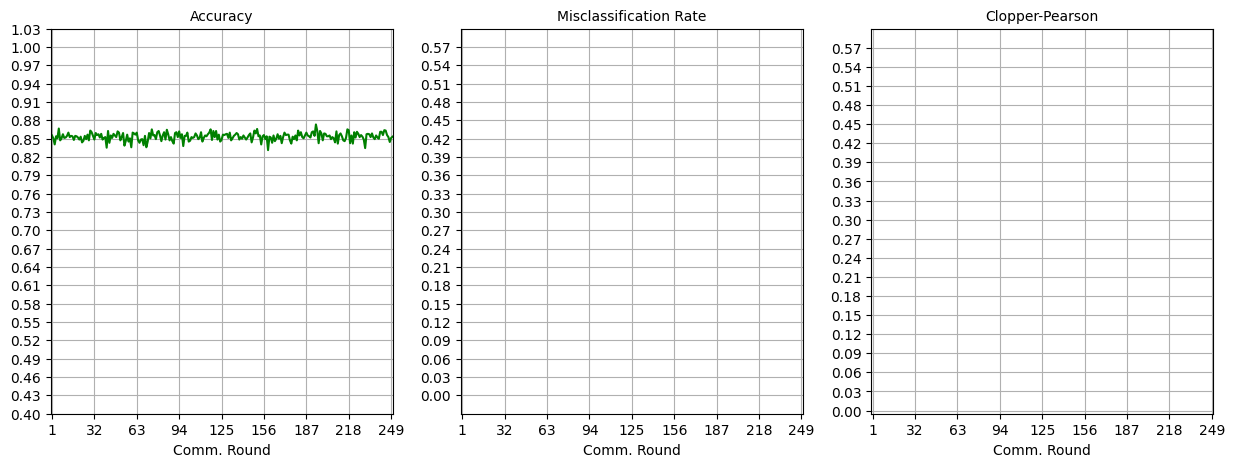

In [33]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(range(250), acc_total, color='green')
plt.title('Accuracy', fontsize=10)
plt.xticks(np.arange(0, 250, 31), np.arange(1, 250, 31))  # Adjust x-axis ticks
plt.yticks(np.arange(0.4, 1.05, 0.03))  # Set y-axis limits and ticks
plt.ylim(0.4, 1.03)  # Set y-axis limits
plt.xlim(-1, 249)  # Set y-axis limits
plt.grid(True)  # Add grid lines
plt.subplots_adjust(hspace=0.28)
plt.xlabel('Comm. Round', fontsize=10, labelpad=None)

fig.add_subplot(132)
plt.plot(range(250), f1_total, color='green')
plt.title('Misclassification Rate', fontsize=10)
plt.xticks(np.arange(0, 251, 31), np.arange(1, 251, 31))  # Adjust x-axis ticks
plt.yticks(np.arange(0, 0.6, 0.03))  # Set y-axis limits and ticks
plt.ylim(-0.03, 0.6)  # Set y-axis limits
plt.xlim(-1, 249)  # Set y-axis limits
plt.grid(True)  # Add grid lines
plt.subplots_adjust(hspace=0.28)
plt.xlabel('Comm. Round', fontsize=10, labelpad=None)

fig.add_subplot(133)
plt.plot(range(250), mcc_total, color='green')
plt.title('Clopper-Pearson', fontsize=10)
plt.xticks(np.arange(0, 251, 31), np.arange(1, 251, 31))  # Adjust x-axis ticks
plt.yticks(np.arange(0, 0.6, 0.03))  # Set y-axis limits and ticks
plt.ylim(-0.005, 0.6)  # Set y-axis limits
plt.xlim(-1, 249)  # Set y-axis limits
plt.grid(True)  # Add grid lines
plt.subplots_adjust(hspace=0.28)
plt.xlabel('Comm. Round', fontsize=10, labelpad=None)
plt.savefig("FL-IRT-results.png") 

plt.show()

In [34]:
def save_results(acc_total, f1_total, mcc_total, number_clients):
    acc_total_GC_MCC_VP = np.array(acc_total)
    f1_total_GC_MCC_VP = np.array(f1_total)
    mcc_total_GC_MCC_VP = np.array(mcc_total)
    
    filename = f'NEW_arrays_VP_HC_MCC_{number_clients}_devices.npy'
    np.save(filename, [acc_total_GC_MCC_VP, f1_total_GC_MCC_VP, mcc_total_GC_MCC_VP])

save_results(acc_total, f1_total, mcc_total, number_clients)

In [22]:
# Calculate summary statistics
avg_tree_size = np.mean(tree_sizes)
std_tree_size = np.std(tree_sizes)
min_tree_size = np.min(tree_sizes)
max_tree_size = np.max(tree_sizes)

avg_tree_depth = np.mean(tree_depths)
std_tree_depth = np.std(tree_depths)
min_tree_depth = np.min(tree_depths)
max_tree_depth = np.max(tree_depths)

avg_internal_nodes = np.mean(tree_internal_nodes)
std_internal_nodes = np.std(tree_internal_nodes)
min_internal_nodes = np.min(tree_internal_nodes)
max_internal_nodes = np.max(tree_internal_nodes)

avg_leaf_nodes = np.mean(tree_leaf_nodes)
std_leaf_nodes = np.std(tree_leaf_nodes)
min_leaf_nodes = np.min(tree_leaf_nodes)
max_leaf_nodes = np.max(tree_leaf_nodes)


avg_model_size = np.mean(model_sizes)
std_model_size = np.std(model_sizes)
min_model_size = np.min(model_sizes)
max_model_size = np.max(model_sizes)

# Save summary statistics
with open("model_summary_6_devices.txt", "w") as f:
    f.write(f"Average Tree Size (Total Nodes): {avg_tree_size}\n")
    f.write(f"Standard Deviation of Tree Size: {std_tree_size}\n")
    f.write(f"Minimum Tree Size: {min_tree_size}\n")
    f.write(f"Maximum Tree Size: {max_tree_size}\n\n")
    
    f.write(f"Average Tree Depth: {avg_tree_depth}\n")
    f.write(f"Standard Deviation of Tree Depth: {std_tree_depth}\n")
    f.write(f"Minimum Tree Depth: {min_tree_depth}\n")
    f.write(f"Maximum Tree Depth: {max_tree_depth}\n\n")
    
    f.write(f"Average Number of Internal Nodes: {avg_internal_nodes}\n")
    f.write(f"Standard Deviation of Internal Nodes: {std_internal_nodes}\n")
    f.write(f"Minimum Number of Internal Nodes: {min_internal_nodes}\n")
    f.write(f"Maximum Number of Internal Nodes: {max_internal_nodes}\n\n")
    
    f.write(f"Average Number of Leaf Nodes: {avg_leaf_nodes}\n")
    f.write(f"Standard Deviation of Leaf Nodes: {std_leaf_nodes}\n")
    f.write(f"Minimum Number of Leaf Nodes: {min_leaf_nodes}\n")
    f.write(f"Maximum Number of Leaf Nodes: {max_leaf_nodes}\n\n")
    
    f.write(f"Average Model Size (bytes): {avg_model_size}\n")
    f.write(f"Standard Deviation of Model Size: {std_model_size}\n")
    f.write(f"Minimum Model Size: {min_model_size}\n")
    f.write(f"Maximum Model Size: {max_model_size}\n")


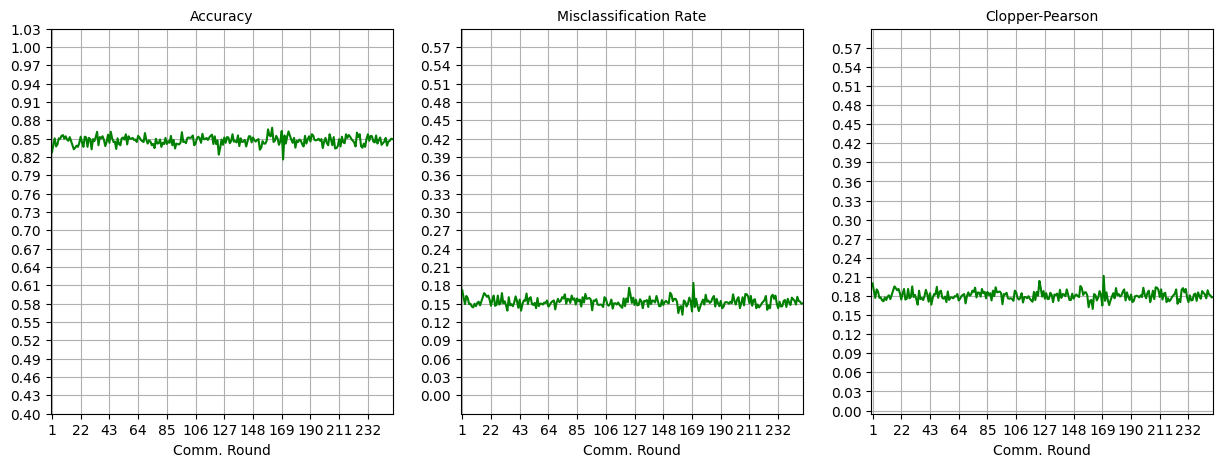

In [12]:
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(range(250), acc_total, color='green')
plt.title('Accuracy', fontsize=10)
plt.xticks(np.arange(0, 251, 21), np.arange(1, 251, 21))  # Adjust x-axis ticks
plt.yticks(np.arange(0.4, 1.05, 0.03))  # Set y-axis limits and ticks
plt.ylim(0.4, 1.03)  # Set y-axis limits
plt.xlim(-1, 249)  # Set y-axis limits
plt.grid(True)  # Add grid lines
plt.subplots_adjust(hspace=0.28)
plt.xlabel('Comm. Round', fontsize=10, labelpad=None)

fig.add_subplot(132)
plt.plot(range(250), miss_total, color='green')
plt.title('Misclassification Rate', fontsize=10)
plt.xticks(np.arange(0, 251, 21), np.arange(1, 251, 21))  # Adjust x-axis ticks
plt.yticks(np.arange(0, 0.6, 0.03))  # Set y-axis limits and ticks
plt.ylim(-0.03, 0.6)  # Set y-axis limits
plt.xlim(-1, 249)  # Set y-axis limits
plt.grid(True)  # Add grid lines
plt.subplots_adjust(hspace=0.28)
plt.xlabel('Comm. Round', fontsize=10, labelpad=None)

fig.add_subplot(133)
plt.plot(range(250), cp_total, color='green')
plt.title('Clopper-Pearson', fontsize=10)
plt.xticks(np.arange(0, 251, 21), np.arange(1, 251, 21))  # Adjust x-axis ticks
plt.yticks(np.arange(0, 0.6, 0.03))  # Set y-axis limits and ticks
plt.ylim(-0.005, 0.6)  # Set y-axis limits
plt.xlim(-1, 249)  # Set y-axis limits
plt.grid(True)  # Add grid lines
plt.subplots_adjust(hspace=0.28)
plt.xlabel('Comm. Round', fontsize=10, labelpad=None)

plt.show()

In [13]:
# Load the arrays
arrays_FEDAVG = np.load('arrays_FEDAVG_VP_fix_250_r_200_6_devices.npy', allow_pickle=True)
[cp_total_FEDAVG, acc_total_FEDAVG,miss_total_FEDAVG] = arrays_FEDAVG

# Load the arrays
arrays_FEDPROX = np.load('arrays_FEDPROX_VP_mu01_250_r_200_6_devices.npy', allow_pickle=True)
[cp_total_FEDPROX, acc_total_FEDPROX,miss_total_FEDPROX] = arrays_FEDPROX

NameError: name 'acc_total_FEDAVG' is not defined

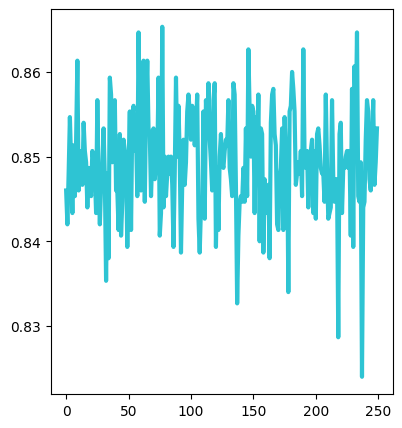

In [15]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15, 5))

# Define colors
blue = '#17BECF'
orange = '#FF7F0E'
pink = '#E377C2'

# First subplot
ax1 = fig.add_subplot(131)
ax1.plot(range(len(acc_total)), acc_total, color=blue, linewidth=3.0, alpha=0.9, label='FL-IRT')
ax1.plot(range(len(acc_total)), acc_total_FEDAVG, color=orange, linestyle='--', linewidth=3.0, alpha=0.9, label='FedAvg')
ax1.plot(range(len(acc_total)), acc_total_FEDPROX, color=pink, linewidth=2.0, alpha=0.9, label='FedProx')
ax1.set_title('Accuracy', fontsize=10)
ax1.legend()
ax1.set_xticks(np.arange(0, len(acc_total)+1, 50))
ax1.set_yticks(np.arange(0.2, 1.05, 0.1))
ax1.set_ylim(0.2, 1.03)
ax1.set_xlim(0, len(acc_total))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('Comm. Round', fontsize=10)  # Add x-axis label

# Second subplot
ax2 = fig.add_subplot(132)
ax2.plot(range(len(miss_total)), miss_total, color=blue, linewidth=3.0, alpha=0.9, label='FL-IRT')
ax2.plot(range(len(miss_total)), miss_total_FEDAVG, color=orange, linestyle='--', linewidth=3.0, alpha=0.9, label='FedAvg')
ax2.plot(range(len(miss_total)), miss_total_FEDPROX, color=pink, linewidth=2.0, alpha=0.9, label='FedProx')
ax2.set_title('Misclassification Rate', fontsize=10)
ax2.legend()
ax2.set_xticks(np.arange(0, len(miss_total)+1, 50))
ax2.set_yticks(np.arange(0, 1.05, 0.1))
ax2.set_ylim(-0.03, 1)
ax2.set_xlim(0, len(miss_total))
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Comm. Round', fontsize=10)  # Add x-axis label

# Third subplot
ax3 = fig.add_subplot(133)
ax3.plot(range(len(cp_total)), cp_total, color=blue, linewidth=3.0, alpha=0.9, label='FL-IRT')
ax3.plot(range(len(cp_total)), cp_total_FEDAVG, color=orange, linestyle='--', linewidth=3.0, alpha=0.9, label='FedAvg')
ax3.plot(range(len(cp_total)), cp_total_FEDPROX, color=pink, markersize=6, linewidth=2.0, alpha=0.9, label='FedProx')
ax3.set_title('Clopper-Pearson', fontsize=10)
ax3.legend()
ax3.set_xticks(np.arange(0, len(cp_total)+1, 50))
ax3.set_yticks(np.arange(0, 1.05, 0.1))
ax3.set_ylim(-0.005, 1)
ax3.set_xlim(0, len(cp_total))
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel('Comm. Round', fontsize=10)  # Add x-axis label

plt.show()

In [15]:
# Save the figure
fig.savefig('./VP_6_devices_200_Samples.png')

# Display the figure (optional)
plt.show()